In [23]:
# Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pytorch_lightning as pl

plt.ion()   # interactive mode

# Refernce notebook: https://jovian.ai/ahmadyahya11/pytorch-transfer-learning

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.1


In [5]:
# Crazy trick to occupy memory?

import os
import torch
from tqdm import tqdm
import time

cuda_device = '0'

def check_mem(cuda_device):
    devices_info = os.popen('"/usr/bin/nvidia-smi" --query-gpu=memory.total,memory.used --format=csv,nounits,noheader').read().strip().split("\n")
    total, used = devices_info[int(cuda_device)].split(',')
    return total,used

def occumpy_mem(cuda_device):
    total, used = check_mem(cuda_device)
    total = int(total)
    used = int(used)
    max_mem = int(total * 0.9)
    block_mem = max_mem - used
    x = torch.cuda.FloatTensor(256,1024,block_mem)
    del x
    
if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
    occumpy_mem(cuda_device)
    for _ in tqdm(range(60)):
        time.sleep(1)
    print('Done')

ValueError: not enough values to unpack (expected 2, got 1)

In [3]:
# Specify device

device = torch.device('cuda')
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


In [4]:
# Data locations, with off the shelf loader
from torchvision import datasets

root = "data/deepfashion/"
train = os.path.join(root, "train")
test = os.path.join(root, "test")
validation = os.path.join(root, "validation")
dry_run_train = os.path.join(root, "dry_run_train")
dry_run_validation = os.path.join(root, "dry_run_validation")

print(os.listdir(root))
print(len(os.listdir(f"{train}/image")))
print(len(os.listdir(f"{test}/image")))
print(len(os.listdir(f"{validation}/image")))

['json_for_validation', 'validation', 'test', 'json_for_test', 'dry_run_validation', 'train', 'dry_run_train']
191961
62629
32153


In [5]:
# Labels
labels = {
    1: "short_sleeve_top",
    2: "long_sleeve_top",
    3: "short_sleeve_outwear",
    4: "long_sleeve_outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short_sleeve_dress",
    11: "long_sleeve_dress",
    12: "vest_dress",
    13: "sling_dress",
}

In [6]:
# Sample annotation
import json

anno = json.load(open("/home/rajkinra23/git/drip_vision/data/deepfashion/train/annos/178255.json"))
labels = []
for k in anno:
    if k.startswith('item'):
        item = anno.get(k)
        print(item.get('category_id'), item.get('bounding_box'))
        labels.append(item.get('category_name'))
        
print(anno)
print(anno.keys())
print(labels)

7 [80, 321, 328, 544]
1 [53, 62, 353, 350]
{'item2': {'segmentation': [[301, 329, 204, 336, 105, 331, 89, 429, 111, 517, 208, 509, 214, 459, 217, 514, 325, 504, 313, 409, 301, 329], [204, 336, 105, 331, 89, 429, 111, 517, 208, 509, 214, 459, 204, 336], [301, 329, 204, 336, 214, 459, 217, 514, 325, 504, 313, 409, 301, 329]], 'scale': 2, 'viewpoint': 2, 'zoom_in': 1, 'landmarks': [105, 331, 1, 204, 336, 2, 301, 329, 1, 89, 429, 1, 111, 517, 2, 208, 509, 2, 214, 459, 2, 217, 514, 2, 325, 504, 2, 313, 409, 2], 'style': 2, 'bounding_box': [80, 321, 328, 544], 'category_id': 7, 'occlusion': 2, 'category_name': 'shorts'}, 'source': 'user', 'pair_id': 13968, 'item1': {'segmentation': [[263, 69, 245, 79, 206, 85, 175, 82, 142, 71, 92, 90, 73, 145, 58, 206, 120, 222, 115, 191, 111, 166, 117, 181, 122, 252, 109, 328, 213, 332, 304, 331, 297, 253, 298, 186, 297, 181, 293, 201, 293, 227, 352, 208, 336, 156, 318, 97, 263, 69], [92, 90, 73, 145, 58, 206, 120, 222, 115, 191, 111, 166, 92, 90], [297, 1

In [7]:
# Dataloader for the deepfashion dataset

import os
import numpy as np
import torch
import json
from PIL import Image

INPUT_W = 224
INPUT_H = 224

# Util to transform a box
def resize_box(box, w, h):
    x_a, y_a, x_b, y_b = box
    x_a *= INPUT_W/w
    x_b *= INPUT_W/w
    y_a *= INPUT_H/h
    y_b *= INPUT_H/h
    return (x_a, y_a, x_b, y_b)

# Util for area of a box, make sure that it's not 0
def area(box):
    x_a, y_a, x_b, y_b = box
    area = (y_b - y_a) * (x_b - x_a)
    return area    

# Dataset class
class DeepfashionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Root directory
        self.root = root
        
        # Transforms
        self.transforms = transforms
        
        # Load the images and the annotations
        self.image_root = os.path.join(root, "image")
        self.annos_root = os.path.join(root, "annos")
        self.imgs = list(sorted(os.listdir(self.image_root)))
        self.annos = list(sorted(os.listdir(self.annos_root)))

    def __getitem__(self, idx):
        # Get the image and correpsonding annotations
        img_path = os.path.join(self.image_root, self.imgs[idx])
        anno_path = os.path.join(self.annos_root, self.annos[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        anno = json.load(open(anno_path))

        # Get the bounding box and label for each iden
        labels = []
        boxes = []
        for k in anno:
            if k.startswith('item'):
                # Get the item, and bounding box and label from said item
                item = anno[k]
                label = item.get('category_name')
                box = item.get('bounding_box')
                
                # Add box and label to accumulated list, if the box has a non zero area.
                if area(box) > 0.0:
                    labels.append(label)
                    boxes.append(box)
        
        # Apply transforms if supplied
        if self.transforms is not None:
            img = self.transforms(img)
            for i in range(len(boxes)):
                boxes[i] = resize_box(boxes[i], w, h)
            
        # Tensorize boxes
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Index can basically serve as the image id
        image_id = torch.tensor([idx])
        
        # Build the targetdevice
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        
        # Return the image and the target labels/boxes
        return img, target

    def __len__(self):
        return len(self.imgs)
    
# Transformer for input. VGG takes 224 x 224 image sizes.
transform = transforms.Compose([transforms.Resize((INPUT_W, INPUT_H)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [8]:
ds = DeepfashionDataset(train, transform)
print(ds[0])

(tensor([[[-0.8902, -0.8824, -0.8902,  ...,  0.7098,  0.8431,  0.9608],
         [-0.8824, -0.8824, -0.8824,  ...,  0.8824,  0.9608,  0.9922],
         [-0.8667, -0.8667, -0.8588,  ...,  0.9843,  0.9922,  0.9843],
         ...,
         [ 0.9059,  0.9059,  0.9059,  ..., -0.4196, -0.1922, -0.1843],
         [ 0.9137,  0.9137,  0.9137,  ..., -0.5765, -0.2549, -0.2314],
         [ 0.9059,  0.9059,  0.9059,  ..., -0.7333, -0.3882, -0.2784]],

        [[-0.6627, -0.6549, -0.6627,  ...,  0.7176,  0.8510,  0.9608],
         [-0.6549, -0.6549, -0.6549,  ...,  0.8902,  0.9608,  0.9922],
         [-0.6392, -0.6392, -0.6314,  ...,  0.9843,  0.9922,  0.9843],
         ...,
         [ 0.9137,  0.9137,  0.9137,  ..., -0.3412, -0.1843, -0.2000],
         [ 0.9216,  0.9216,  0.9216,  ..., -0.4667, -0.2235, -0.2157],
         [ 0.9137,  0.9137,  0.9137,  ..., -0.5843, -0.3176, -0.2392]],

        [[-0.6000, -0.5922, -0.6000,  ...,  0.6784,  0.8353,  0.9608],
         [-0.5922, -0.5922, -0.5922,  ...,  

In [9]:
# Visualize some of the data
from PIL import Image, ImageDraw, ImageFont

def visualize(datapoint):
    # Get image tensor and target
    img, target = datapoint
    
    # Convert image to PIL
    img = transforms.ToPILImage()(img)
    
    # Annotate and draw
    annotated_image = img
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Draw boxestop_labels, boxes, scores)
    for box in target.get("boxes"):
        box = box.tolist()
        draw.rectangle(xy=box, outline='#000000')
        draw.rectangle(xy=[l + 1. for l in box], outline='#000000')
        
    # Return image
    return annotated_image
        
visualize(ds[33])
print(ds[33][1])
s = "short sleeve top,long sleeve top,short sleeve outwear,long sleeve outwear,vest,sling,shorts,trousers,skirt,short sleeve dress,long sleeve dress,vest dress,sling dress"
labels = s.split(",")
print(labels)

{'boxes': tensor([[108.1500,   0.0000, 216.6500,  56.4667],
        [ 85.4000,  40.3667, 191.8000, 103.8333]]), 'labels': ['short sleeve top', 'shorts'], 'image_id': tensor([33])}
['short sleeve top', 'long sleeve top', 'short sleeve outwear', 'long sleeve outwear', 'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short sleeve dress', 'long sleeve dress', 'vest dress', 'sling dress']


In [10]:
# Check memory and clean up before training again

def print_allocated_memory():
    print("{:.2f} GB".format(torch.cuda.memory_allocated() / 1024 ** 3))
    
print_allocated_memory()

0.00 GB


In [66]:
# Train using detecto (maybe)
from detecto.core import Model, DataLoader
from detecto import utils, visualize

# Clear torch cache
torch.cuda.empty_cache()

# Get the train dataset
train_dataset = DeepfashionDataset(train, transform)
validation_dataset = DeepfashionDataset(validation, transform)
dry_run_train_dataset = DeepfashionDataset(dry_run_train, transform)
dry_run_validation_dataset = DeepfashionDataset(dry_run_validation, transform)

# Loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dry_run_train_dataloader = DataLoader(dry_run_train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)

# Load Model
checkpoint_dir = "models"
checkpoint_prefix = "deep_fashion_t_shirt_detector"
checkpoints = []
for f in os.listdir(checkpoint_dir):
    if f.startswith(checkpoint_prefix):
        checkpoints.append(os.path.join(checkpoint_dir, f))
    checkpoints.sort()
    
if checkpoints:
    print("Found checkpoints: {}".format(checkpoints))
    latest_checkpoint = checkpoints[-1]
    model = Model.load(latest_checkpoint, labels)
    last_epoch = len(checkpoints)
else:
    print("No checkpoints found in directory {}. Starting a new mdoel.".format(checkpoints))
    model = Model(labels, device=device)
    last_epoch = 0

Found checkpoints: ['models/deep_fashion_t_shirt_detector_1.pth', 'models/deep_fashion_t_shirt_detector_2.pth', 'models/deep_fashion_t_shirt_detector_3.pth', 'models/deep_fashion_t_shirt_detector_4.pth', 'models/deep_fashion_t_shirt_detector_5.pth', 'models/deep_fashion_t_shirt_detector_6.pth', 'models/deep_fashion_t_shirt_detector_7.pth', 'models/deep_fashion_t_shirt_detector_8.pth']


In [10]:
# Check memory again

print_allocated_memory()

0.00 GB


In [13]:
# I/O to write losses to redis
import redis

r = redis.Redis(decode_responses=True)

def key(epoch):
    return f"{checkpoint_prefix}_{epoch}_loss"

def write(epoch, loss):
    r.set(key(epoch), loss)
    
def get(epoch):
    return r.get(key(epoch))

print(last_epoch)

8


In [12]:
# Train. Store loss data per epoch
import json

# Number of epochs to train
EPOCHS = 10

# Dry run flag
DRY_RUN = False

# Train one epoch at a time (this browser sometimes can crash, might need to interrupt, etc...)
for epoch in range(last_epoch + 1, EPOCHS + 1):
    next_checkpoint = f'{checkpoint_prefix}_{epoch}.pth'
    print("Training {}".format(next_checkpoint))
    if DRY_RUN:
        losses = model.fit(dry_run_train_dataloader, dry_run_validation_dataset, epochs=1,
                       learning_rate=0.001, verbose=True)
    else:
        losses = model.fit(train_dataloader, validation_dataset, epochs=1,
                       learning_rate=0.001, verbose=True)
        
    # Write loss
    write(epoch, losses[0])

    # Save model at each iteration step.
    print("Saving model!")
    model.save(os.path.join(checkpoint_dir, next_checkpoint))

Training deep_fashion_t_shirt_detector_9.pth
It looks like you're training your model on a CPU. Consider switching to a GPU; otherwise, this method can take hours upon hours or even days to finish. For more information, see https://detecto.readthedocs.io/en/latest/usage/quickstart.html#technical-requirements
Epoch 1 of 1
Begin iterating over training dataset


  0%|                                                                                                                                                                                                                                | 0/11998 [00:00<?, ?it/s]/home/rajkinra23/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                                                                                                                                                                | 0/11998 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# Visualize losses
losses = [get(epoch) for epoch in range(1, 8)]

# Do something with losses when training is done? XD
print(losses)

['0.16872970477778074', '0.15120049996814625', '0.14182547530195214', '0.1404932834897039', '0.14001511353003837', '0.13570339270204884', '0.13481296070467624']


/home/rajkinra23/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


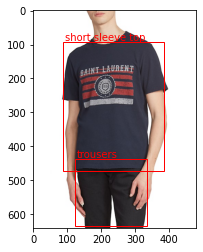

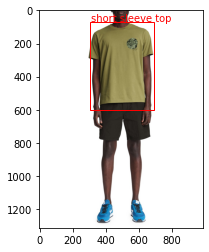

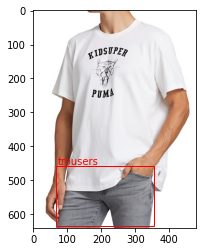

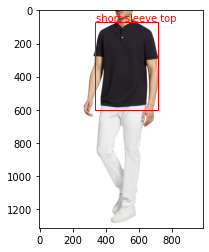

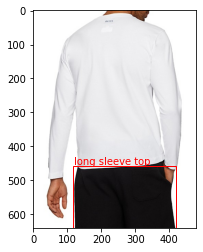

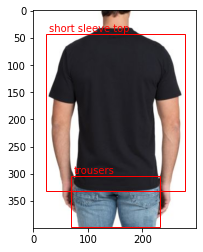

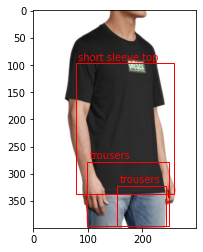

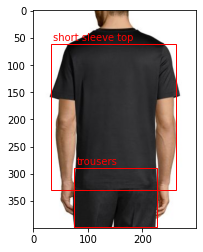

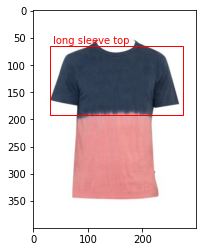

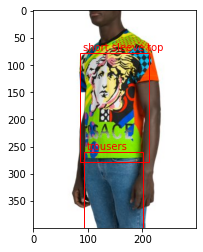

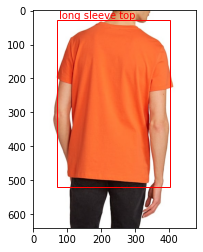

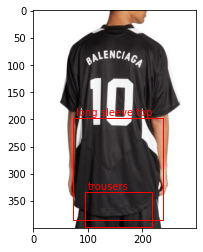

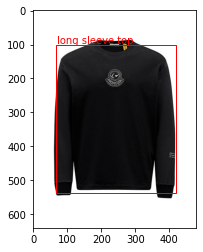

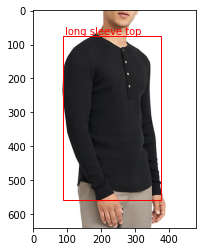

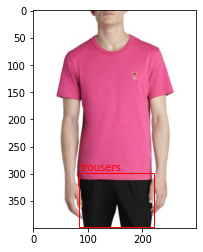

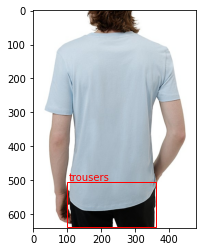

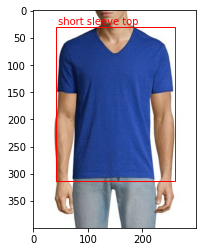

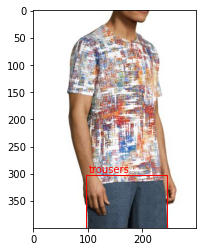

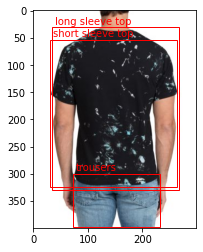

In [15]:
# Try visualizing model on the embeddings dataset
from detecto import utils, visualize
from detecto.core import Model, DataLoader
import random
import os

s = "short sleeve top,long sleeve top,short sleeve outwear,long sleeve outwear,vest,sling,shorts,trousers,skirt,short sleeve dress,long sleeve dress,vest dress,sling dress"
labels = s.split(",")

SCRAPED_DATASET_ROOT = "/home/rajkinra23/git/drip_vision/data/scraped_dataset/train"

def random_image(use_scraped_dataset=True):
    if use_scraped_dataset:
        root = SCRAPED_DATASET_ROOT
        product_ids = os.listdir(root) 
        random_prodict_id = os.path.join(root, random.choice(product_ids))
        product_dir = os.path.join(root, random_prodict_id)
        images = os.listdir(product_dir)
        random_image = os.path.join(product_dir, random.choice(images))
        return random_image
    else:
        root = "/home/rajkinra23/git/drip_vision/data/deepfashion/validation/image"
        images = os.listdir(root)
        random_image = os.path.join(root, random.choice(images))
        return random_image

checkpoint = 'models/deep_fashion_t_shirt_detector_4.pth'
model = Model.load(checkpoint, labels)
for _ in range(40):
    img = random_image(True)
    image = utils.read_image(img)
    top_labels, boxes, scores = model.predict(image)
    threshold = 0.6
    i = 0
    if len(scores) > 0:
        while i < len(scores) and scores[i] >= threshold:
            i += 1
        if i > 0:
            visualize.show_labeled_image(image, boxes[:i], top_labels[:i])

In [56]:
# Plotting model performance
torch_model = model.get_internal_model()
print(type(torch_model))
print(type(torch_model.backbone))

<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
<class 'torchvision.models.detection.backbone_utils.BackboneWithFPN'>


In [80]:
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',
    dirpath=checkpoint_dir,
    filename='deep_fashion_t_shirt_detector_{epoch:02d}',
    auto_insert_metric_name=False
)

# Model conversion from detecto --> pytorch lightning
class DeepFashionDetector(LightningModule):
    def __init__(self):
        super(DeepFashionDetector, self).__init__()
        self.model = Model.load(latest_checkpoint, labels).get_internal_model()
        print('Model created!')
        
    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location='cuda:0'), strict=False)
        
    def training_step(self, train_batch, batch_idx):
        return self.model.training_step(train_batch, batch_idx)
    
    def configure_optimizers(self):
        return torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    def train_dataloader(self):
        return self.model.train_dataloader()
        
model = DeepFashionDetector()
model.load_model(checkpoints[-1])

print('configure_optimizers' )

# Train
trainer = Trainer()
trainer.fit(
    model,
    train_dataloader,
    validation_dataloader
)


Model created!


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MisconfigurationException: No `configure_optimizers()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.